KNN CV Scores: [0.98823529 0.98823529 0.97647059 1.         0.99408284]
Random Forest CV Scores: [1. 1. 1. 1. 1.]
Decision Tree CV Scores: [1. 1. 1. 1. 1.]
SVM CV Scores: [1. 1. 1. 1. 1.]
Meilleur modèle : Random Forest avec une accuracy de 1.00
Matrice de confusion :
 [[74  0]
 [ 0 96]]
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00        96

    accuracy                           1.00       170
   macro avg       1.00      1.00      1.00       170
weighted avg       1.00      1.00      1.00       170



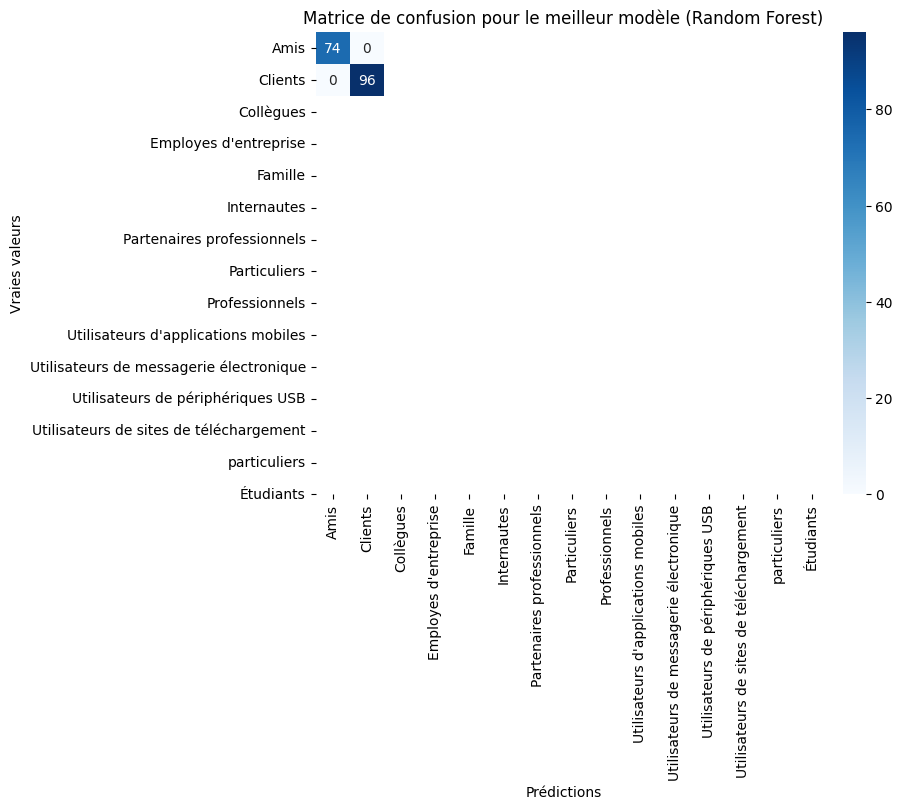

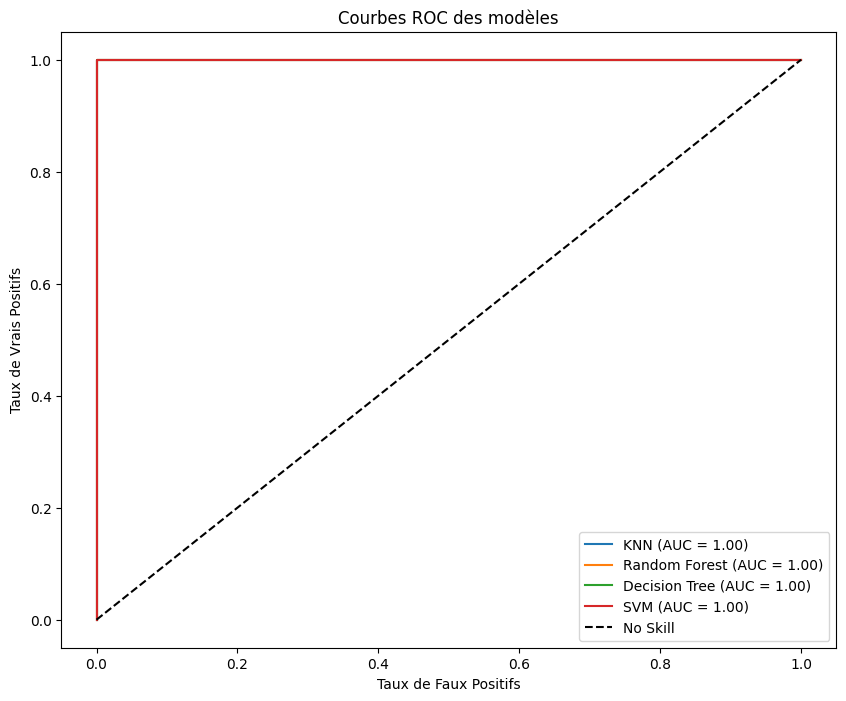

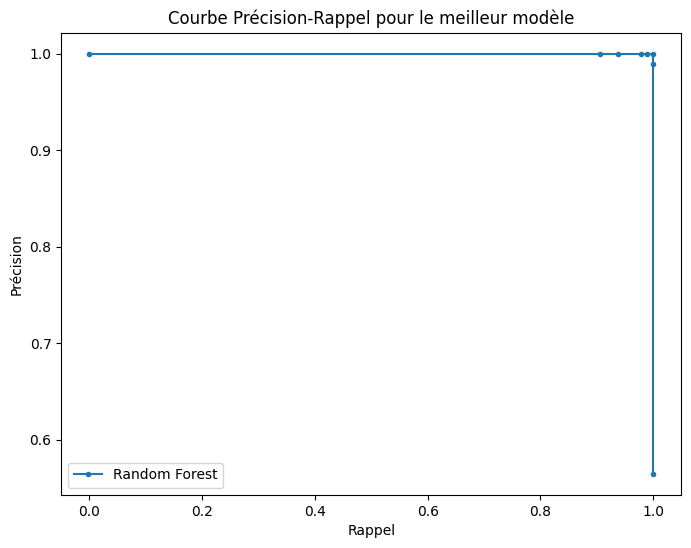

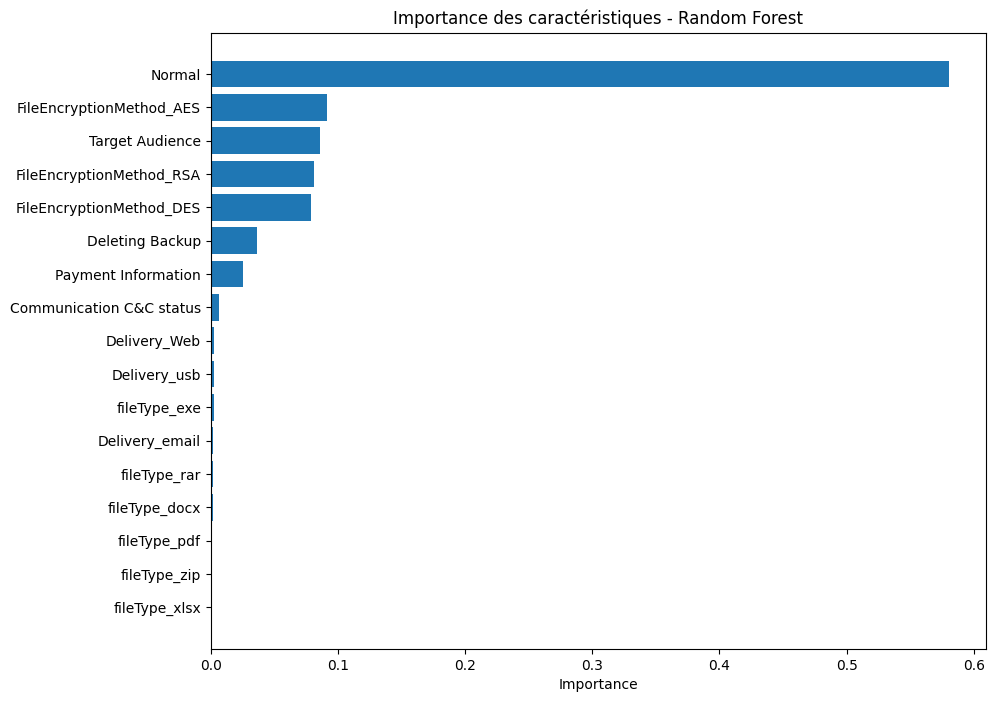

['label_encoder.pkl']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE
import joblib

# Chargement des données
data = pd.read_excel("data1.xlsx")

# Encodage de la colonne 'Target Audience'
label_encoder = LabelEncoder()
data['Target Audience'] = label_encoder.fit_transform(data['Target Audience'])

# Préparation des données
X = data.drop(columns=['Hacker', 'Id'])  # Suppression de la colonne 'Id' qui n'est pas nécessaire pour le modèle
y = data['Hacker']

# Choisir un prétraitement : StandardScaler
scaler = StandardScaler()  # Vous pouvez changer par MinMaxScaler() ou RobustScaler()
X_scaled = scaler.fit_transform(X)

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

# Sur-échantillonnage des classes (si nécessaire)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Entraînement des modèles avec hyperparamètres ajustés

# KNN
knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan')  # Exemple d'ajustement
knn.fit(X_train_res, y_train_res)
y_pred_knn = knn.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

# Decision Tree
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=5, criterion='entropy', random_state=42)
dt.fit(X_train_res, y_train_res)
y_pred_dt = dt.predict(X_test)

# SVM
svm = SVC(C=1.0, kernel='rbf', probability=True, random_state=42)  # Ajustement des hyperparamètres
svm.fit(X_train_res, y_train_res)
y_pred_svm = svm.predict(X_test)

# Évaluation des performances avec la validation croisée
cv_scores_knn = cross_val_score(knn, X_scaled, y, cv=5)
cv_scores_rf = cross_val_score(rf, X_scaled, y, cv=5)
cv_scores_dt = cross_val_score(dt, X_scaled, y, cv=5)
cv_scores_svm = cross_val_score(svm, X_scaled, y, cv=5)

print(f"KNN CV Scores: {cv_scores_knn}")
print(f"Random Forest CV Scores: {cv_scores_rf}")
print(f"Decision Tree CV Scores: {cv_scores_dt}")
print(f"SVM CV Scores: {cv_scores_svm}")

# Sélection du meilleur modèle basé sur la moyenne de la validation croisée
model_accuracies = {
    "KNN": np.mean(cv_scores_knn),
    "Random Forest": np.mean(cv_scores_rf),
    "Decision Tree": np.mean(cv_scores_dt),
    "SVM": np.mean(cv_scores_svm)
}

best_model_name = max(model_accuracies, key=model_accuracies.get)
best_model = {'KNN': knn, 'Random Forest': rf, 'Decision Tree': dt, 'SVM': svm}[best_model_name]

# Afficher la matrice de confusion et le rapport de classification pour le meilleur modèle
y_pred_best = best_model.predict(X_test)
print(f"Meilleur modèle : {best_model_name} avec une accuracy de {model_accuracies[best_model_name]:.2f}")
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_best))
print("Rapport de classification :\n", classification_report(y_test, y_pred_best))

# Visualisation de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(f"Matrice de confusion pour le meilleur modèle ({best_model_name})")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")

# Sauvegarde de la matrice de confusion
plt.savefig('confusion_matrix_best_model.png')  # Sauvegarde en fichier PNG
plt.show()

# Courbe ROC et AUC pour chaque modèle
plt.figure(figsize=(10, 8))
for model_name, model in zip(["KNN", "Random Forest", "Decision Tree", "SVM"], [knn, rf, dt, svm]):
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_prob = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label="No Skill")
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title("Courbes ROC des modèles")
plt.legend()
plt.show()

# Courbe de Précision-Rappel pour le meilleur modèle
if hasattr(best_model, "predict_proba"):
    y_pred_prob_best = best_model.predict_proba(X_test)[:, 1]
else:
    y_pred_prob_best = best_model.decision_function(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_best)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'{best_model_name}')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title("Courbe Précision-Rappel pour le meilleur modèle")
plt.legend()
plt.show()

# Importance des caractéristiques pour le Random Forest (si Random Forest est le meilleur modèle)
if best_model_name == "Random Forest":
    feature_importances = rf.feature_importances_
    features = X.columns
    indices = np.argsort(feature_importances)[::-1]
    plt.figure(figsize=(10, 8))
    plt.title("Importance des caractéristiques - Random Forest")
    plt.barh(range(len(features)), feature_importances[indices], align="center")
    plt.yticks(range(len(features)), [features[i] for i in indices])
    plt.gca().invert_yaxis()
    plt.xlabel("Importance")
    plt.show()

# Sauvegarde du meilleur modèle, scaler et label encoder
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

In [5]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le modèle, le scaler, et le label encoder
best_model = joblib.load('best_model.pkl')
scaler = joblib.load('scaler.pkl')
label_encoder = joblib.load('label_encoder.pkl')

# Liste complète des valeurs possibles pour 'Target Audience'
target_audience_values = ["Particuliers", "Utilisateurs de périphériques USB", ...]

label_encoder.fit(target_audience_values)

def predire(data_simulation):
    if 'Target Audience' in data_simulation:
        try:
            data_simulation['Target Audience'] = label_encoder.transform([data_simulation['Target Audience']])[0]
        except ValueError as e:
            print(f"Erreur lors de l'encodage du 'Target Audience': {e}")
            return None

    df_simulation = pd.DataFrame([data_simulation])
    expected_columns = scaler.feature_names_in_
    for col in set(expected_columns) - set(df_simulation.columns):
        df_simulation[col] = 0

    df_simulation = df_simulation[expected_columns]
    features = scaler.transform(df_simulation.values)
    prediction = best_model.predict(features)[0]
    return prediction

def enregistrer_donnees_csv(data_simulation, filename='predictions.csv'):
    header_needed = not os.path.exists(filename)
    pd.DataFrame([data_simulation]).to_csv(filename, mode='a', header=header_needed, index=False)

def calculer_matrice_confusion(filename='predictions.csv'):
    if not os.path.exists(filename):
        print(f"Erreur : le fichier {filename} est introuvable.")
        return None
    df = pd.read_csv(filename)
    y_true = df['Hacker']
    y_pred = df['Prediction']
    return confusion_matrix(y_true, y_pred)

def sauvegarder_matrice_confusion(matrix, filename='matrice_confusion.png'):
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Hacker', 'Hacker'], yticklabels=['Non Hacker', 'Hacker'])
    plt.xlabel('Prédictions')
    plt.ylabel('Réel')
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['ellipsis', 'str']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Chargement des données
data = pd.read_excel("data1.xlsx")

# Encodage de la colonne 'Target Audience'
label_encoder = LabelEncoder()
data['Target Audience'] = label_encoder.fit_transform(data['Target Audience'])

# Préparation des données
X = data.drop(columns=['Hacker', 'Id'])  # Suppression de la colonne 'Id' qui n'est pas nécessaire pour le modèle
y = data['Hacker']

# Mise à l'échelle des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entraînement des modèles
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Évaluation des performances
model_accuracies = {
    "KNN": accuracy_score(y_test, y_pred_knn),
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "Decision Tree": accuracy_score(y_test, y_pred_dt),
    "SVM": accuracy_score(y_test, y_pred_svm)
}

# Sélection du meilleur modèle
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_model = {'KNN': knn, 'Random Forest': rf, 'Decision Tree': dt, 'SVM': svm}[best_model_name]

# Afficher la matrice de confusion et le rapport de classification pour le meilleur modèle
y_pred_best = best_model.predict(X_test)
print(f"Meilleur modèle : {best_model_name} avec une accuracy de {model_accuracies[best_model_name]:.2f}")
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_best))
print("Rapport de classification :\n", classification_report(y_test, y_pred_best))

# Sauvegarde du meilleur modèle, scaler et label encoder
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')